# Demonstrate the Utility of a Differentially Private Release by Simulation

This notebook provides shows how to numerically approximate the amount of utility of a differentially private release over different dataset sizes, and different ranges of the privacy loss parameter, epsilon.

### Set up libraries and load exemplar dataset

In [1]:
# load libraries
import os
import opendp.whitenoise.core as wn
import numpy as np
import math

# establish data information
data_path = os.path.join('.', 'data', 'PUMS_california_demographics_1000', 'data.csv')
var_names = ["age", "sex", "educ", "race", "income", "married"]

data = np.genfromtxt(data_path, delimiter=',', names=True)
age = list(data[:]['age'])

print("Dimension of dataset: " + str(data.shape))
print("Names of variables:   " + str(data.dtype.names))

Dimension of dataset: (1000,)
Names of variables:   ('age', 'sex', 'educ', 'race', 'income', 'married')


### Construct a loglinear sequence of parameters to run repeated simulations over, to demonstrate utility

We want to simulate over different sizes of dataset, and different values of the privacy parameter, epsilon.  However, as we will see, roughly logarithmic changes in these two underlying values will be linearly related to our measure of utility, so we first set up values to iterate over.

In [2]:
n_sims = 100
def logsequence(start, stop, num, base=10, decimals=2, asint=False):
    my_seq = np.linspace(start=math.log10(start), stop=math.log10(stop), num=num)
    my_seq = np.power(10, my_seq)
    if asint:
        my_seq = list(my_seq.round().astype(int))
    else:
        my_seq = my_seq.round(decimals=decimals)
    return my_seq

n_seq = logsequence(start=200, stop=1500, num=10, asint=True)
epsilon_seq = logsequence(start=1, stop=0.01, num=4, decimals=2)

print("Sequence of dataset sizes:  " + str(n_seq))
print("Sequence of epsilon values: " + str(epsilon_seq))

Sequence of dataset sizes:  [200, 250, 313, 391, 490, 613, 766, 959, 1199, 1500]
Sequence of epsilon values: [1.   0.22 0.05 0.01]


### Bootstrap the data and generate DP releases over different dataset sizes and values of epsilon

Our dataset has 1000 observations, but we are going to simulate with many different scales of dataset.  In each simulation we will create a new dataset by sampling with replacement (bootstrapping) observations from the original dataset.  Thus, for the purposes of this simulation, we are treating the original dataset as if it were representative of a population, and creating possible plausible datasets that might have been drawn from that population.

We'll also vary the privacy-loss parameter, epsilon.  Finally, at each dataset size and epsilon, we'll run many simulations so we can average them together so as to get a clear picture of average expected behavior.

All of these simulations we'll store together in some arrays we can generate plots from later.

In [3]:
rawhistory = np.zeros(shape=(len(n_seq)*len(epsilon_seq)*n_sims, 4), dtype=float)
agghistory = np.zeros(shape=(len(n_seq)*len(epsilon_seq), 3), dtype=float)

temp_data_path = os.path.join('.', 'data', 'PUMS_california_demographics_1000', 'temp.csv')

rawcount = -1
aggcount = -1

for i in n_seq:
    for j in epsilon_seq:
        aggcount += 1
        error = [0] * n_sims
        for k in range(n_sims):
            rawcount += 1
            
            # Mean release
            tempdata = np.random.choice(a=age, size=i)
            np.savetxt(fname=temp_data_path, X=tempdata, delimiter=',', header='age', comments="")
            
            
            with wn.Analysis() as analysis:
                # load data
                data = wn.Dataset(path = temp_data_path, column_names = ["age"])

                # get mean of age
                age_mean = wn.dp_mean(data = wn.to_float(data['age']),
                          privacy_usage = {'epsilon': j},
                          data_lower = 0.,
                          data_upper = 100.,
                          data_n = i
                         )
            analysis.release()
            
            release = age_mean.value
            sample_truth = tempdata.mean()
            error[k] = sample_truth - release
     
            rawhistory[rawcount, 0] = i
            rawhistory[rawcount, 1] = j
            rawhistory[rawcount, 2] = release
            rawhistory[rawcount, 3] = sample_truth
        
        agghistory[aggcount, 0] = i
        agghistory[aggcount, 1] = j
        agghistory[aggcount, 2] = math.sqrt(np.power(error,2).mean())

        
print("Example simulations: \n")
print(agghistory[0:5])  

Example simulations: 

[[2.00000000e+02 1.00000000e+00 6.49453005e-01]
 [2.00000000e+02 2.20000000e-01 3.23033088e+00]
 [2.00000000e+02 5.00000000e-02 1.61613851e+01]
 [2.00000000e+02 1.00000000e-02 8.94899060e+01]
 [2.50000000e+02 1.00000000e+00 5.72472737e-01]]


### Plot the simulations of error against sample size for different epsilon values

We've measured utility by mean squared error between the differentially private released mean, and the "true" mean in the bootstrapped dataset.  In such simulations it's key to decide whether "truth" means the value in the sample data at hand, or "truth" means the value in the population that data was drawn from.  Which is more relevant depends on context, and the goal of the researcher.  

In these simulations, we've decided we're interested in the mean in the dataset at hand, not an inference against the population at large.

Here we plot the average root mean squared error (RMSE) in our simulations, for any epsilon and dataset set size, $N$.

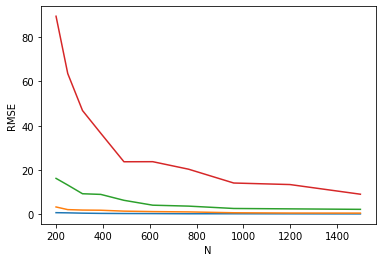

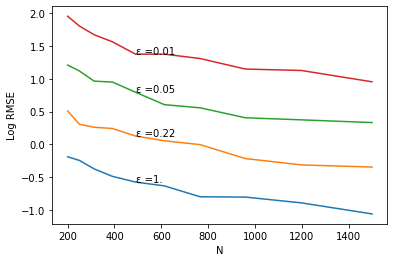

In [4]:
import matplotlib
import matplotlib.pyplot as plt

for epsilon in epsilon_seq:
    flag = agghistory[:,1] == epsilon
    plt.plot(agghistory[flag, 0], agghistory[flag, 2]) 
  
plt.ylabel('RMSE')
plt.xlabel('N')
plt.show()

xloc = round(len(n_seq)*0.4)
for epsilon in epsilon_seq:
    flag = agghistory[:,1] == epsilon
    subhistory = agghistory[flag,:]
    plt.plot(subhistory[:, 0], np.log10(subhistory[:, 2])) 
    plt.text(x=subhistory[xloc,0] , y=np.log10(subhistory[xloc,2]), s="\u03B5 =" + np.array2string(subhistory[0,1]) )
    
plt.ylabel('Log RMSE')
plt.xlabel('N')
plt.show()

We see clearly the two guiding rules of differentially private means:
1. Higher values of epsilon, mean more privacy loss, and thus less error.
2. Larger dataset sizes mean any individual is contributing less to the mean, thus less noise is required to mask their possible contribution, so again, there is less error.

In the graphs above, we see that on a logarithmic changes in epsilon result in logarithmic changes in RMSE.